# Bayesian Computational Imaging with Pyxu

In this guide, we will walk you through how to use Pyxu to solve a MAP estimation problem from a Bayesian definition of an inverse problem. We will go step by step, relating text, equations, and code to provide a clear understanding of the process.

## Understanding the Problem

From a Bayesian perspective, the inverse problem is formulated as finding the most credible image $\hat{\mathbf{x}}$ given the measured (degraded) image $\mathbf{y}$, the model of the measurement (a.k.a. the forward model) $\mathbf{F}$, and a prior probability over the distribution of $\mathbf{x}$. In this scenario, we are trying to find the best possible original image ($\mathbf{x}$) given the degraded image we have ($\mathbf{y}$). This is known as the maximum a posteriori (MAP) estimate, defined by the equation:

$$\hat{\mathbf{x}}_{MAP} = \arg \max_{\mathbf{x}} p(\mathbf{x} | \mathbf{y}) = \arg \max_{\mathbf{x}} \frac{p(\mathbf{y}|\mathbf{x}) p(\mathbf{x})}{p(\mathbf{y})},$$

where:
   * $p(\mathbf{x}|\mathbf{y})$ is the Posterior Probability: It gives us a measure of how probable a specific version of the original image is, given the degraded image we are observing. Essentially, it helps us to estimate the most credible original image considering the information we have from the degraded image.
   * $p(\mathbf{y}|\mathbf{x})$ is the Likelihood Function: In the process of image degradation, various forms of noise such as blurring, salt-and-pepper noise, or Gaussian noise can be introduced, altering the original image and resulting in a degraded version. The noise model is essentially a mathematical representation of how this noise affects the image. The likelihood function models how likely we are to observe the degraded image ($\mathbf{y}$) given a specific version of the original image ($\mathbf{x}$) and the noise model.  
   * $p(\mathbf{x})$ defines the Prior: The prior is our initial belief or assumption about the original image before we even look at the degraded image. For instance, we might assume that the image has smooth regions, sharp edges, or certain statistical properties.
   * $p(\mathbf{y})$: This term represents the probability of observing the degraded image without considering any information about the original image. In the context of finding the most probable original image, this term does not provide any useful information because it is not influenced by the original image ($\mathbf{x}$). Therefore, it does not help in improving our estimate of the original image and can be safely ignored during the reconstruction process.

## Step 2: Simplifying the Optimization Problem

To simplify the optimization problem, we take the negative log-transform of the posterior distribution, allowing us to minimize over a sum instead of maximizing over a product:
$$\hat{\mathbf{x}}_{MAP} 
    &= \arg \min_{\mathbf{x}} \left\{ - \log p(\mathbf{x} | \mathbf{y}) \right\} \\
    &= \arg \min_{\mathbf{x}} \left\{- \log p(\mathbf{y}|\mathbf{x})  - \log p(\mathbf{x})\right\}.$$
    
## Step 3: Defining the Likelihood Function

It is common to assume that the noise in our sensors follows a Gaussian distribution, in that case, the likelihood function can also be defined by a Gaussian distribution:
$$p(\mathbf{y} | \mathbf{x} )= \prod_{i=0}^{M-1} \frac{1}{\sigma\sqrt{2\pi}} \exp \left\{- \frac{1}{2\sigma^{2}} \left(y_{i} - \mathbf{F}_{i}^{\top} \mathbf{x} \right)^{2}  \right\}$$

where $\sigma_{i} = \sigma$ defines the standard deviation of the Gaussian distribution at each sensor. After applying the negative log-transform, results in a quadratic term plus a constant term. Ignoring the constant term (as it does not affect the optimizer argument), we obtain the well-known least-squares form:
$$- \log p(\mathbf{y} | \mathbf{x} )= \frac{1}{2\sigma^{2}} \Vert \mathbf{y} - \mathbf{F}\mathbf{x} \Vert^{2}_{2}. $$


### Table 1: Choice of cost functional based on noise modeling

| Noise Type      | Noise PDF                                                         | Cost Functional, $F(\mathbf{y}, \mathbf{G}\mathbf{x})$ |
|-----------------|-------------------------------------------------------------------|--------------------------------------------------------|
| Noiseless       | $p_\mathbf{n}(y)=0$                                               | $\i(\mathbf{y} - \mathbf{G}\mathbf{x}) = \begin{cases} 0,& \text{if } \mathbf{y} = \mathbf{G}\mathbf{x} \\ \infty, & \text{o.w.}\end{cases}$ |
| Gaussian Noise  | $p_\mathbf{n}(y) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{1}{2\sigma^2} \mathbf{y}^T \mathbf{y} \right)$ | $||\mathbf{y} - \mathbf{G}\mathbf{x}||_2^2$             |
| Laplacian Noise | $p_\mathbf{n}(y) = \frac{1}{2\sigma}\exp \left( -\frac{|x|}{\sigma} \right)$ | $||\mathbf{y} - \mathbf{G}\alpha||_1$                   |

## Step 4: Defining the Prior Distribution

For the prior distribution, we will assume that the signal \mathbf{x} is piece wise constant. This is equivalent as saying that its gradient is sparse, and is well modeled by the Laplacian probability distribution on the gradient coefficients:

$$p(\mathbf{x}) = \prod_{i=0}^{N-1}\frac{1}{2\beta}  \exp \left\{ - \frac{|\mathbf{D}(\mathbf{x})_{i} |}{\beta} \right\},$$

where $\beta$ is the [scale parameter](https://en.wikipedia.org/wiki/Scale_parameter), related to the standard deviation. After applying the negative log-transform and ignoring the constant term, results in the $L1$-norm:
$$ - \log p(\mathbf{x}) = \frac{1}{\beta} \Vert \mathbf{D}\mathbf{x}\Vert_{1}.$$

### Table 2: Choice of regularising functional based on a priori knowledge

| Regularization Type | Apriori Information                                              | Regularising Functional, $R(\alpha)$ |
|---------------------|------------------------------------------------------------------|--------------------------------------|
| Tikhonov           | $p_\alpha (\alpha) \propto \exp \left( - ||\alpha||_2^2 \right) $ | $||\alpha||_2$                       |
| Generalised Tikhonov | $p_\alpha (\alpha) \propto \exp \left( - ||\mathbf{D} \alpha||_2^2 \right)$ | $||\mathbf{D}\alpha||_2$              |
| $\ell_1$           | $p_\alpha (\alpha) \propto \exp \left( - ||\alpha||_1 \right)$    | $||\alpha||_1$                       |
| Total Variation     | $p_\alpha (\alpha) \propto \exp \left( - ||\mathbf{D} \alpha||_1 \right)$ | $||\mathbf{D} \alpha||_1$             |



## Step 5: Combining the Likelihood and Prior

Combining the likelihood and prior, we can rewrite the optimization problem as:
$$\hat{\mathbf{x}}_{MAP} 
&= \arg \min_{\mathbf{x}} \frac{1}{2\sigma^{2}} \Vert \mathbf{y} - \mathbf{F}\mathbf{x} \Vert^{2}_{2} + \frac{1}{\beta} \Vert \mathbf{D}^{\top}\mathbf{x}\Vert_{1} \\
&= \arg \min_{\mathbf{x}} \Vert \mathbf{y} - \mathbf{F}\mathbf{x} \Vert^{2}_{2} + \frac{2\sigma^{2}}{\beta} \Vert \mathbf{D}^{\top}\mathbf{x}\Vert_{1} \\
&= \arg \min_{\mathbf{x}} \Vert \mathbf{y} - \mathbf{F}\mathbf{x} \Vert^{2}_{2} + \lambda \Vert \mathbf{D}^{\top}   \mathbf{x}\Vert_{1},$$

where $\lambda = \frac{2\sigma^{2}}{\beta}$ defines the uncertainty trade-off between the likelihood and the prior.

## Step 6: Implementing with Pyxu

Now, we will implement the above formulation using Pyxu. First, import the necessary modules:


```python
import pyxu.abc as pxa
import pyxu.operator as pxo
from pyxu.operator import Gradient, SquaredL2Norm, L1Norm, PositiveL1Norm
```

Next, define the TV prior, positivity + L1 norm, loss, and posterior:


```python
# TV prior
grad = Gradient(arg_shape=x.shape)
lambda_= 0.05 / (2 * sigma**2)
l1_norm = L1Norm(grad.shape[0])
tv_prior = lambda_ * l1_norm * grad

# Positivity + L1 norm
posL1_prior = 0.05 * PositiveL1Norm(x.size)

# Loss
loss = (1/ (2 * sigma**2)) * SquaredL2Norm(dim=data.size).asloss(data) * Phi

# Posterior
posterior = loss + tv_prior + posL1_prior
```

Finally, define the solver and call the fit method to trigger the solver:


```python
from pyxu.opt.solver import CV

# Define the solver
solver = CV(f=loss, g=posL1_prior,h=lambda_ * l1_norm, K=grad, show_progress=False)

# Call fit to trigger the solver
solver.fit(x0=0*x.size, acceleration=True)
recon_tv = solver.solution()
```

In the above code:

    * `x`.shape refers to the shape of your input image
    * `sigma` is the standard deviation of the noise
    * `data` refers to your input data
    * `Phi` is the forward model

This will give you the reconstructed image in recon_tv. You have now successfully used Pyxu to solve a MAP estimation problem from a Bayesian definition of an inverse problem. Adjust the parameters as necessary to suit your specific problem.

In [2]:
import pyxu.abc as pxa
import pyxu.operator as pxo
import numpy as np
from pyxu.operator import Gradient, SquaredL2Norm, L1Norm, PositiveL1Norm
from PIL import Image

# Load the data
toucan = np.array(Image.open("../_static/favicon.png").convert("L"))
toucan = toucan.astype(float)
toucan /= toucan.max()

# Create noisy data
sigma = 0.2
Phi = pxo.IdentityOp(toucan.size) # This is not really necessary, but we will use it for consistency
data = Phi(toucan) + sigma * np.random.randn(*toucan.shape)
data = np.clip(data, 0, 1)
# TV prior
grad = Gradient(arg_shape=toucan.shape, accuracy=4,)
lambda_= 1000 / (2 * sigma**2)
l1_norm = lambda_ * L1Norm(grad.shape[0])

In [5]:
out = grad.unravel(grad(toucan.ravel()))

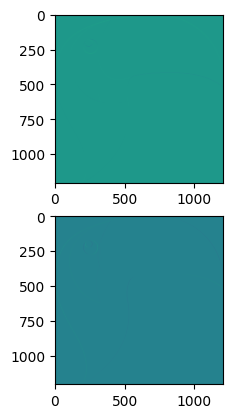

In [6]:
import matplotlib.pyplot as plt
plt.subplot(211)
plt.imshow(out[0])
plt.subplot(212)
plt.imshow(out[1])

In [14]:
# Loss
loss = (1/ (2 * sigma**2)) * SquaredL2Norm(dim=data.size).asloss(data.ravel()) * Phi
loss.diff_lipschitz = loss.estimate_diff_lipschitz()
# Posterior
#posterior = loss + tv_prior + posL1_prior
# posterior_smooth =  loss + tv_prior
# posterior_smooth.diff_lipschitz = posterior_smooth.estimate_diff_lipschitz()

from pyxu.opt.solver import PGD
from pyxu.opt.solver import CV
# Define the solver
# solver = CV(f=loss, g=posL1_prior, h=lambda_ * l1_norm, K=grad, show_progress=False)
solver = CV(f=loss,h=l1_norm, K=grad, show_progress=True, verbosity=100)
# solver = PGD(f=posterior_smooth, g=posL1_prior, show_progress=True,)

In [15]:
import pyxu.opt.stop as pxst
stop_crit = pxst.RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) | pxst.MaxIter(500)

In [16]:
# Call fit to trigger the solver
solver.fit(x0=data.ravel(), stop_crit=stop_crit)
recon_tv = solver.solution().reshape(toucan.shape)

INFO -- [2023-09-14 17:25:05.231025] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
INFO -- [2023-09-14 17:25:05.350278] Iteration 1
	iteration: 1
	RelError[x]: 0.0009056601887591996
	N_iter: 2.0
INFO -- [2023-09-14 17:25:05.350952] Stopping Criterion satisfied -> END


In [17]:
np.allclose(recon_tv, data)

False

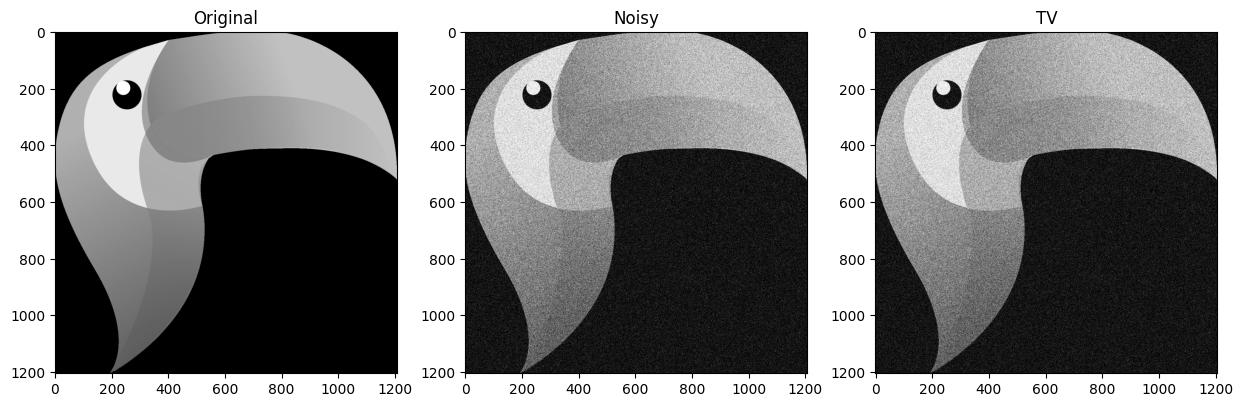

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(toucan, cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(data, cmap="gray")
ax[1].set_title("Noisy")
ax[2].imshow(recon_tv, cmap="gray")
ax[2].set_title("TV")
plt.show()

In [19]:
4.2 + 4.6 + 8.8

17.6